## Get similarity between pipes

### Extract semantic features for each pipe

In [1]:
from graph_utils import networkx, extract_features_from_nx_graph

g_nx_leakdb = networkx("KGS/knowledge_graph1-LeakDB.ttl")

In [2]:
pipe_features = extract_features_from_nx_graph(
    g_nx_leakdb,
   "https://raw.githubusercontent.com/DiTEC-project/wdn-knowledge-graph/refs/heads/main/wdn_ontology.ttl",
    node_type_filter="Pipe",  # Or full URI if you want
    attribute_keys=["diameter", "length", "roughness", "status"],
    edge_predicates=None
)

In [3]:
pipe_features

{'Pipe_30': {'diameter': 0.4122381,
  'length': 1997.237,
  'roughness': 126.4847,
  'status': 'Open'},
 'Pipe_31': {'diameter': 0.2942326,
  'length': 1553.082,
  'roughness': 121.5079,
  'status': 'Open'},
 'Pipe_7': {'diameter': 1.056082,
  'length': 837.9012,
  'roughness': 127.8199,
  'status': 'Open'},
 'Pipe_17': {'diameter': 0.5142606,
  'length': 1773.933,
  'roughness': 137.0129,
  'status': 'Open'},
 'Pipe_5': {'diameter': 1.090574,
  'length': 1451.77,
  'roughness': 140.6532,
  'status': 'Open'},
 'Pipe_26': {'diameter': 0.4774439,
  'length': 825.7778,
  'roughness': 132.1164,
  'status': 'Open'},
 'Pipe_25': {'diameter': 0.7376673,
  'length': 1256.235,
  'roughness': 127.0521,
  'status': 'Open'},
 'Pipe_33': {'diameter': 0.4413251,
  'length': 892.1622,
  'roughness': 126.9478,
  'status': 'Open'},
 'Pipe_4': {'diameter': 1.046316,
  'length': 1177.574,
  'roughness': 139.6072,
  'status': 'Open'},
 'Pipe_12': {'diameter': 0.6100255,
  'length': 3352.516,
  'roughness'

### Normalize and standardize features

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelBinarizer
from itertools import combinations
import numpy as np

# Collect features
pipe_ids = list(pipe_features.keys())

# Prepare numeric features
lengths, diameters, roughnesses, statuses = [], [], [], []
connected_sets, node_sets = [], []

for pid in pipe_ids:
    f = pipe_features[pid]

    lengths.append(f["length"])
    diameters.append(f["diameter"])
    roughnesses.append(f["roughness"])
    statuses.append(f["status"])
 

# Scale numeric and binary features
scaler = StandardScaler()
numeric_features = scaler.fit_transform(np.array([lengths, diameters, roughnesses]).T)

lb = LabelBinarizer()
status_encoded = lb.fit_transform(statuses)

combined_features = np.hstack((numeric_features, status_encoded))
eucl_dist_matrix = euclidean_distances(combined_features)

# Step 2: Convert distance to similarity and scale
norm_eucl_dist = eucl_dist_matrix / eucl_dist_matrix.max()
eucl_sim_matrix = 1 - norm_eucl_dist  # now higher = more similar

final_similarity = eucl_dist_matrix

# Optional: Convert to distance matrix if using clustering
final_distance = 1 - final_similarity


In [5]:
combined_features

array([[ 1.10967251, -0.87101256, -0.48325967,  0.        ],
       [ 0.51757691, -1.28808553, -1.17186702,  0.        ],
       [-0.43581866,  1.40455842, -0.29851676,  0.        ],
       [ 0.81198968, -0.51042913,  0.97345868,  0.        ],
       [ 0.38251957,  1.52646529,  1.47714324,  0.        ],
       [-0.45198016, -0.64055231,  0.29596192,  0.        ],
       [ 0.12185513,  0.27916879, -0.40475224,  0.        ],
       [-0.36348423, -0.76820886, -0.41918355,  0.        ],
       [ 0.01699347,  1.37004194,  1.33241505,  0.        ],
       [ 2.91637228, -0.17196226, -0.09207845,  0.        ],
       [-0.25869375, -0.58870937, -1.48613199,  0.        ],
       [ 0.23019748,  1.03314821, -1.32284925,  0.        ],
       [-1.17195751, -1.35830781,  0.26123269,  0.        ],
       [-0.85613528, -0.87808232,  1.09308774,  0.        ],
       [-0.4847936 , -0.79933873,  1.73539867,  0.        ],
       [ 0.52200008, -0.84869065,  0.61197026,  0.        ],
       [ 0.03787222,  0.

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# assuming combined_features is your normalized feature matrix (NumPy array or DataFrame)
inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(combined_features)
    inertias.append(kmeans.inertia_)


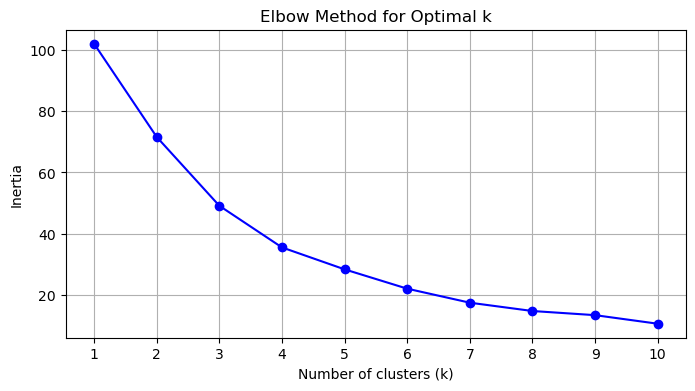

In [7]:
# Plotting the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [11]:
# Cluster
from collections import defaultdict


kmeans = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans.fit(combined_features)

pipe_clusters = dict(zip(pipe_ids, kmeans.labels_))
# 
clusters = defaultdict(list)
# Example: print each pipe with its assigned cluster
for pipe, cluster in pipe_clusters.items():
    clusters[cluster].append(pipe)

for cluster_id, pipes in clusters.items():
    print(len(pipes))
    print(f"Cluster {cluster_id}: {', '.join(sorted(pipes))}")


10
Cluster 3: Pipe_10, Pipe_18, Pipe_2, Pipe_21, Pipe_22, Pipe_25, Pipe_30, Pipe_31, Pipe_33, Pipe_34
10
Cluster 0: Pipe_1, Pipe_11, Pipe_24, Pipe_3, Pipe_4, Pipe_5, Pipe_6, Pipe_7, Pipe_8, Pipe_9
10
Cluster 1: Pipe_13, Pipe_14, Pipe_15, Pipe_17, Pipe_19, Pipe_26, Pipe_27, Pipe_28, Pipe_29, Pipe_32
4
Cluster 2: Pipe_12, Pipe_16, Pipe_20, Pipe_23
